In [1]:
import numpy as np
import random as rand
import matplotlib.pyplot as plt
from queue import Queue

In [2]:
class Arm:
    def __init__(self, mean, std_dev):
        self.mean = mean
        self.std_dev = std_dev
        self.mu_hat = 0
        self.times_pulled = 0

    def pull(self):
        reward = rand.gauss(self.mean, self.std_dev)
        self.mu_hat = ((self.mu_hat * self.times_pulled) + reward) / (self.times_pulled + 1)
        self.times_pulled += 1
        return reward

    def hoeffding(self, delta):
        return np.exp(-2*(delta**2)*(self.times_pulled))

In [3]:
class Arm:
    def __init__(self, mean, std_dev):
        self.mean = mean                            #List of means of each attribute
        self.std_dev = std_dev                      #List of standard deviations
        self.mu_hat = 0
        self.times_pulled = 0                       #Number of times the arm is pulled

    def pull(self):
        reward = rand.gauss(self.mean, self.std_dev)
        self.mu_hat = ((self.mu_hat * self.times_pulled) + reward) / (self.times_pulled + 1)
        self.times_pulled += 1
        return reward

    def hoeffding(self, delta):
        return np.exp(-2*(delta**2)*(self.times_pulled))
    
    def lcb(self, delta):
        return self.mu_hat - self.hoeffding(delta)
    
    def ucb(self, delta):
        return self.mu_hat + self.hoeffding(delta)
    
    def reset(self):
        self.mu_hat = 0
        self.times_pulled = 0

In [4]:
# arm_params is of the form [(mean1, std_dev1), (mean2, std_dev2), ...]
def action_elimination_with_window(arm_params, delta, uniform_exp, window_size, max_iterations = None, debug_print = False):
    # initialize the arms
    num_arms = len(arm_params)
    arms = [Arm(params[0], params[1]) for params in arm_params]

    # initialize the queue
    times_pulled_queue = Queue(window_size)
    times_pulled = np.zeros(num_arms)
    for _ in range(window_size):
        times_pulled_queue.put(np.zeros(num_arms))
    times_pulled_window = []

    # core of the action elimination algorithm
    omega_curr = list(range(num_arms))
    time = 0
    while len(omega_curr) > (1 if max_iterations is None else 0) and (time < max_iterations if max_iterations is not None else True):
        ref_arm = arms[max(omega_curr, key = lambda arm_index: arms[arm_index].ucb(delta))]
        for arm_index in omega_curr:
            for _ in range(uniform_exp):
                arms[arm_index].pull()

        for arm_index in range(num_arms):
            times_pulled[arm_index] = arms[arm_index].times_pulled
        
        if debug_print:
            print(times_pulled)

        times_pulled_window.append(times_pulled - times_pulled_queue.get())
        times_pulled_queue.put(np.copy(times_pulled))

        omega_next = []
        for arm_index in omega_curr:
            if ref_arm.lcb(delta) <= arms[arm_index].ucb(delta):
                omega_next.append(arm_index)
        omega_curr = omega_next
        time += 1

        if debug_print:
            print(omega_curr)
    
    return omega_curr, time, times_pulled_window

In [5]:
action_elimination_with_window([(1, 0.5),
                                (0.8, 0.5),
                                (0.6, 0.5),
                                (0.4, 0.5),
                                (0.2, 0.5),
                                (0, 0.5)], delta = 0.2, uniform_exp = 3, window_size = 6, max_iterations = 30, debug_print = True)

[3. 3. 3. 3. 3. 3.]
[0, 1, 2, 3, 4, 5]
[6. 6. 6. 6. 6. 6.]
[0, 1, 2, 3, 4, 5]
[9. 9. 9. 9. 9. 9.]
[0, 1, 2, 3, 5]
[12. 12. 12. 12.  9. 12.]
[0, 1, 2]
[15. 15. 15. 12.  9. 12.]
[0, 1, 2]
[18. 18. 18. 12.  9. 12.]
[0, 1, 2]
[21. 21. 21. 12.  9. 12.]
[0, 1]
[24. 24. 21. 12.  9. 12.]
[0, 1]
[27. 27. 21. 12.  9. 12.]
[0, 1]
[30. 30. 21. 12.  9. 12.]
[0, 1]
[33. 33. 21. 12.  9. 12.]
[0, 1]
[36. 36. 21. 12.  9. 12.]
[0, 1]
[39. 39. 21. 12.  9. 12.]
[0, 1]
[42. 42. 21. 12.  9. 12.]
[0, 1]
[45. 45. 21. 12.  9. 12.]
[0, 1]
[48. 48. 21. 12.  9. 12.]
[0, 1]
[51. 51. 21. 12.  9. 12.]
[0, 1]
[54. 54. 21. 12.  9. 12.]
[0, 1]
[57. 57. 21. 12.  9. 12.]
[0]
[60. 57. 21. 12.  9. 12.]
[0]
[63. 57. 21. 12.  9. 12.]
[0]
[66. 57. 21. 12.  9. 12.]
[0]
[69. 57. 21. 12.  9. 12.]
[0]
[72. 57. 21. 12.  9. 12.]
[0]
[75. 57. 21. 12.  9. 12.]
[0]
[78. 57. 21. 12.  9. 12.]
[0]
[81. 57. 21. 12.  9. 12.]
[0]
[84. 57. 21. 12.  9. 12.]
[0]
[87. 57. 21. 12.  9. 12.]
[0]
[90. 57. 21. 12.  9. 12.]
[0]


([0],
 30,
 [array([3., 3., 3., 3., 3., 3.]),
  array([6., 6., 6., 6., 6., 6.]),
  array([9., 9., 9., 9., 9., 9.]),
  array([12., 12., 12., 12.,  9., 12.]),
  array([15., 15., 15., 12.,  9., 12.]),
  array([18., 18., 18., 12.,  9., 12.]),
  array([18., 18., 18.,  9.,  6.,  9.]),
  array([18., 18., 15.,  6.,  3.,  6.]),
  array([18., 18., 12.,  3.,  0.,  3.]),
  array([18., 18.,  9.,  0.,  0.,  0.]),
  array([18., 18.,  6.,  0.,  0.,  0.]),
  array([18., 18.,  3.,  0.,  0.,  0.]),
  array([18., 18.,  0.,  0.,  0.,  0.]),
  array([18., 18.,  0.,  0.,  0.,  0.]),
  array([18., 18.,  0.,  0.,  0.,  0.]),
  array([18., 18.,  0.,  0.,  0.,  0.]),
  array([18., 18.,  0.,  0.,  0.,  0.]),
  array([18., 18.,  0.,  0.,  0.,  0.]),
  array([18., 18.,  0.,  0.,  0.,  0.]),
  array([18., 15.,  0.,  0.,  0.,  0.]),
  array([18., 12.,  0.,  0.,  0.,  0.]),
  array([18.,  9.,  0.,  0.,  0.,  0.]),
  array([18.,  6.,  0.,  0.,  0.,  0.]),
  array([18.,  3.,  0.,  0.,  0.,  0.]),
  array([18.,  0.,  0.,

In [6]:
arm_params = [(1, 0.5),
              (0.8, 0.5),
              (0.6, 0.5),
              (0.4, 0.5),
              (0.2, 0.5),
              (0, 0.5)]

iterations = 5000
average = []

for iteration in range(iterations):
    _, __, result = action_elimination_with_window(arm_params, delta = 0.1, uniform_exp = 3, window_size = 6, max_iterations = 80)
    for i, pulls in enumerate(result):
        if i < len(average):
            average[i] = average[i]*(iteration/(iteration + 1)) + pulls/(iteration + 1)
        else:
            average.append(pulls)
    
for i in range(len(average)):
    average[i] /= np.sum(average[i])

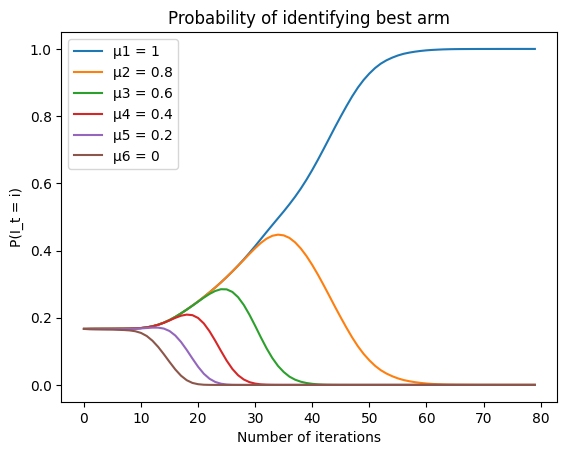

In [11]:
plt.plot(average)
plt.xlabel("Number of iterations")
plt.ylabel("P(I_t = i)")
plt.title("Probability of identifying best arm")
plt.legend(["µ1 = 1", "µ2 = 0.8", "µ3 = 0.6", "µ4 = 0.4", "µ5 = 0.2", "µ6 = 0"])
plt.show()

In [ ]:
# window_size = 2
# times_pulled_queue = Queue(window_size)
# times_pulled = np.zeros(number_of_arms)
# for _ in range(window_size):
#     times_pulled_queue.put(np.zeros(number_of_arms))
# times_pulled_window = []

# sigma_curr = list(range(number_of_arms))
# while len(sigma_curr) > 1:
#     ref_arm = arms[max(sigma_curr, key = lambda arm_index: arms[arm_index].mu_hat + arms[arm_index].hoeffding(delta))]
#     for arm_index in sigma_curr:
#         for time in range(r_k):
#             arms[arm_index].pull()

#     for arm_index in range(number_of_arms):
#         times_pulled[arm_index] = arms[arm_index].times_pulled

#     print(times_pulled)
    
#     times_pulled_window.append(times_pulled - times_pulled_queue.get())
#     times_pulled_queue.put(np.copy(times_pulled))

#     sigma_next = []
#     for arm in sigma_curr:
#         if ref_arm.mu_hat - ref_arm.hoeffding(delta) < arms[arm].mu_hat + arms[arm].hoeffding(delta):
#             sigma_next.append(arm)
#     sigma_curr = sigma_next
#     print(sigma_curr)

# print(times_pulled_window)

[3. 3. 3. 3. 3.]
[0, 1, 2, 3, 4]
[6. 6. 6. 6. 6.]
[0, 1, 2, 3, 4]
[9. 9. 9. 9. 9.]
[0, 1, 2, 3, 4]
[12. 12. 12. 12. 12.]
[0, 1, 2, 3, 4]
[15. 15. 15. 15. 15.]
[0, 1, 2, 3]
[18. 18. 18. 18. 15.]
[0, 1, 2, 3]
[21. 21. 21. 21. 15.]
[0, 1, 2]
[24. 24. 24. 21. 15.]
[0, 1, 2]
[27. 27. 27. 21. 15.]
[0, 1, 2]
[30. 30. 30. 21. 15.]
[0, 1]
[33. 33. 30. 21. 15.]
[0]
[array([3., 3., 3., 3., 3.]), array([6., 6., 6., 6., 6.]), array([6., 6., 6., 6., 6.]), array([6., 6., 6., 6., 6.]), array([6., 6., 6., 6., 6.]), array([6., 6., 6., 6., 3.]), array([6., 6., 6., 6., 0.]), array([6., 6., 6., 3., 0.]), array([6., 6., 6., 0., 0.]), array([6., 6., 6., 0., 0.]), array([6., 6., 3., 0., 0.])]


In [ ]:
#Verifying
for arm in arms:
    print(arm.mean)

0.3442281211937118
0.9534035783962823
0.44135141597582783
0.9613507879975518
0.8916442322857603
0.26203469730840556
0.8273971784763899
0.8311651391691043
0.39545122157778123
0.8574503267409479
0.4804000632364749
0.6144820423145548
0.8664596414680171
0.6043160242025677
